# Starter Code for Drug Experience Team Project

In this notebook, we build two machine learning models to predict the severity of a medication. The target variable is a binary variable. We first build a gradient boosting machine. Then we build a LSTM classifier. We use each one of the two models to create the submission files for Kaggle.  

In [1]:
# Import packages:

import os 
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# sklearn imports:
import sklearn
from sklearn import tree
from sklearn.metrics import * 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# tensorflow imports:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import losses
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# keras imports:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session

# import and load spaCy:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from spacy import displacy
# spacy.cli.download("en_core_web_sm")
nlp = spacy.load('en_core_web_sm') 

%matplotlib inline
plt.rcParams['figure.figsize'] = (5, 5)

## 1. Read the Data Files

Let's go ahead and read the data file:

In [2]:
df = pd.read_csv('data/orig_DrugExp_Text.csv', sep='|')
df.head()

,label,text
0,-1,Schizophrenia Only been on it one day. I took ...
1,-1,Cancer drug arimidex gave me osteoporosis Took...
2,-1,Osteoporosis Dysphagia (inability to swallow)....
3,-1,Ostoclerosis Took it at 630 am by 230pm receiv...
4,-1,Osteopenia My limbs feel like I have weights t...


By looking at the shape of the data file, we realize that we have 9523 samples and two columns:

In [3]:
df.shape

(9523, 2)

The target variable is a binary variable called label, which has two possible values: -1 for negative experience and 1 for positive experience: 

In [4]:
df.label.value_counts()

-1    5072
 1    4451
Name: label, dtype: int64

## 2. Pre-processing

As we discussed previously, we have to pre-process our text data before using them in a machine learning model. So we use the powerful package spaCy to tokenize, lemmatize, remove stop words, and keep alphabetical characters:

In [5]:
tqdm.pandas()
df['text'] = df.text.progress_apply(lambda text: 
                                          " ".join(token.lemma_ for token in nlp(text) 
                                                   if not token.is_stop and token.is_alpha))

/home/greermp/.local/lib/python3.8/site-packages/tqdm/std.py:702: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 9523/9523 [01:57<00:00, 80.97it/s]


In the cell above, we replaced the original text data with the new text data. The data looks pretty similar, but the only difference is that the new data has the pre-processed text:

In [6]:
df.head()

,label,text
0,-1,Schizophrenia day take morning direct sleep da...
1,-1,cancer drug arimidex give osteoporosis Took ac...
2,-1,Osteoporosis Dysphagia inability swallow sever...
3,-1,Ostoclerosis take receive sharp pain rt hip la...
4,-1,Osteopenia limb feel like weight tie fever chi...


Given that pre-processing the text is a time-consuming process, we can save the cleaned data for later use:

In [7]:
# Save the file with pre-processed text for later use:

df.to_csv('data/orig_DrugExp_Text_Clean.csv', sep='|', index=False)

**The next time we start the notebook, we can read this data file instead of the original data file:**

In [8]:
df = pd.read_csv("data/orig_DrugExp_Text_Clean.csv", sep = "|")

In [9]:
df.head()

,label,text
0,-1,Schizophrenia day take morning direct sleep da...
1,-1,cancer drug arimidex give osteoporosis Took ac...
2,-1,Osteoporosis Dysphagia inability swallow sever...
3,-1,Ostoclerosis take receive sharp pain rt hip la...
4,-1,Osteopenia limb feel like weight tie fever chi...


## 3. Vectorization

We can now use CountVectorizer or TfidfVectorizer to create the document-term-matrix (DTM):

In [10]:
# vectorizer = CountVectorizer(min_df=10)
vectorizer = TfidfVectorizer(min_df=10, 
                             ngram_range=(1,2) # We use both unigrams and bigrams
                            )
x = vectorizer.fit_transform(df.text)

In [32]:
len(vectorizer.vocabulary_)

6804

In [29]:
vectorizer.vocabulary_

{'schizophrenia': 5149,
 'day': 1174,
 'take': 5810,
 'morning': 3979,
 'direct': 1487,
 'sleep': 5381,
 'till': 6084,
 'go': 2530,
 'fall': 2112,
 'wall': 6457,
 'thought': 6062,
 'get': 2468,
 'feel': 2166,
 'like': 3406,
 'drunk': 1752,
 'alcohol': 149,
 'hit': 2881,
 'head': 2737,
 'walk': 6453,
 'straight': 5658,
 'sit': 5358,
 'lie': 3368,
 'room': 5099,
 'vertigo': 6406,
 'tell': 5938,
 'dr': 1631,
 'stop': 5619,
 'appt': 285,
 'effect': 1801,
 'day take': 1276,
 'take morning': 5875,
 'sleep day': 5383,
 'feel like': 2205,
 'like drunk': 3421,
 'walk straight': 6455,
 'stop take': 5650,
 'cancer': 716,
 'drug': 1675,
 'give': 2509,
 'osteoporosis': 4294,
 'actonel': 67,
 'bone': 605,
 'specialist': 5493,
 'expect': 2023,
 'acid': 50,
 'reflux': 4974,
 'hour': 2940,
 'pill': 4608,
 'wake': 6443,
 'night': 4135,
 'shiver': 5273,
 'ache': 42,
 'especially': 1978,
 'upper': 6331,
 'leg': 3343,
 'nausea': 4056,
 'phone': 4596,
 'gp': 2611,
 'advice': 115,
 'scared': 5145,
 'step': 5

## 4. Train and Test the Classifier

Now let's try to build the classifier. We try two algorithms below: 1- GBM and 2- LSTM:

### 4.1. Gradient Boosting Machines

In [11]:
trainData, testData, trainLabels, testLabels = train_test_split(x, df.label.values, 
                                                                test_size=.2,
                                                                random_state = 1)

In [12]:
gbClassifier = GradientBoostingClassifier(random_state = 1) # Create gbClassifier object
gbClassifier.fit(trainData, trainLabels) # Train gbClassifier using the function .fit

predictions = gbClassifier.predict(testData) # Predict labels
predictionProbabilities = gbClassifier.predict_proba(testData) # Predict label probabilities

Now we can evaluate the model by calculating performance metrics, creating confusion matrix, and creating the ROC curve:

In [13]:
from custom_funcs import *

In [14]:
calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

Accuracy: 77.69
PrecisionNegative: 77.91
PrecisionPositive: 77.40
RecallNegative: 81.92
RecallPositive: 72.72
AUC Score: 84.88



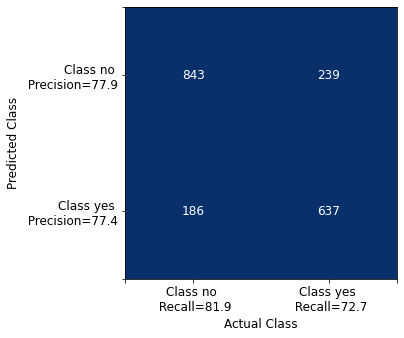

In [15]:
confusionMatrix = None # Remove any previously created confusion matrix
confusionMatrix = confusion_matrix(testLabels, predictions) # Create new confusion matrix
plt.rcParams['figure.figsize'] = (5, 5) # Determine the size of the plot
displayConfusionMatrix(confusionMatrix) # Display the plot

AUC Score = 84.879


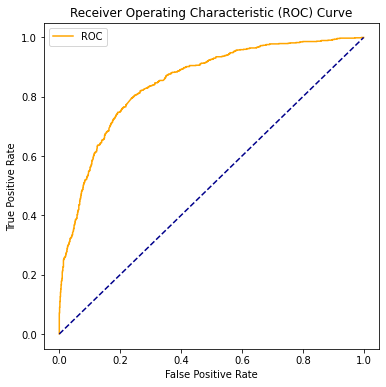

In [16]:
pos_probs = predictionProbabilities[:, 1] # Get probabilities for the positive class

fpr, tpr, thresholds = roc_curve(testLabels, pos_probs, pos_label = 1) # Calculate FPR and TPR

lr_auc = roc_auc_score(testLabels, pos_probs) # Calculate AUC score
plt.rcParams['figure.figsize'] = (5, 5) # Determine the size of the plot
custom_plot_roc_curve(fpr, tpr, lr_auc) # Display ROC plot

### 4.2. LSTM Model

Now we can go ahead and build a LSTM model instead of GBM. We first separate the text from the labels:

In [17]:
X = df.text
Y = df.label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

We then split the data to train/ test:

In [18]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state = 1)

We prepare the text data that will be received in the input layer:

In [33]:
max_words = 6500
max_len = 300
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len) #pads sequences

In [39]:
len(sequences)

7618

In [40]:
sequences[0] # a sentence 

[257,
 4,
 1000,
 3004,
 116,
 244,
 218,
 173,
 29,
 418,
 1661,
 283,
 779,
 645,
 418,
 686,
 8,
 1147,
 223,
 2,
 15,
 418,
 1661,
 2341,
 37,
 4894,
 2,
 418,
 887,
 2,
 2246,
 418,
 84,
 2,
 45,
 231,
 418,
 2247,
 71,
 7,
 7,
 158,
 28,
 1662,
 132,
 2246,
 329,
 10,
 329,
 32,
 28,
 369,
 21,
 12,
 1941,
 12,
 2,
 7,
 2530,
 298,
 147]

Now we can use Keras to design our model:

In [34]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,100,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

Now we can compile our model:

In [35]:
# Clear previous model:
clear_session()

lstm_model = RNN()
lstm_model.summary()
lstm_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['AUC'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 100)          650000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257   

Now we can fit our model using our data:

In [36]:
lstm_model.fit(sequences_matrix,
               Y_train,
               batch_size=110, # Really means number of batches  (divide all samples by batch size to get size of each batch)
               # IF you raise your batch_size,you are feeding less observations, it will be worse...
               # Use a large batch size when tuning, then turn it down
               epochs=10, # Increasing the epochs, the whole process is going to happen that many times
               validation_split=0.2,
               callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
56/56 [==============================] - 12s 179ms/step - loss: 0.6417 - auc: 0.6803 - val_loss: 0.4348 - val_auc: 0.8836
Epoch 2/10
56/56 [==============================] - 10s 171ms/step - loss: 0.3711 - auc: 0.9152 - val_loss: 0.4800 - val_auc: 0.8775


To evaluate our model, we need to process the test data the same way we processed our train data:

In [37]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

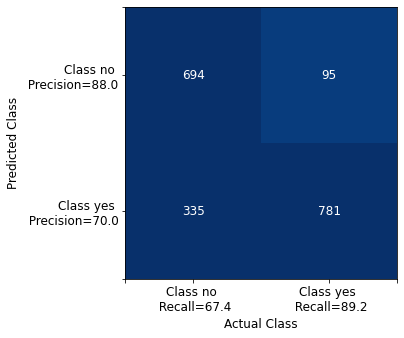

In [38]:
predictions = (lstm_model.predict(test_sequences_matrix) > 0.5).astype("int32").flatten() # Get the prediction labels

confusionMatrix = None # Remove any previously created confusion matrix
confusionMatrix = confusion_matrix(Y_test, predictions) # Create new confusion matrix
plt.rcParams['figure.figsize'] = (5, 5) # Determine the size of the plot
displayConfusionMatrix(confusionMatrix) # Display the plot

AUC Score = 87.440


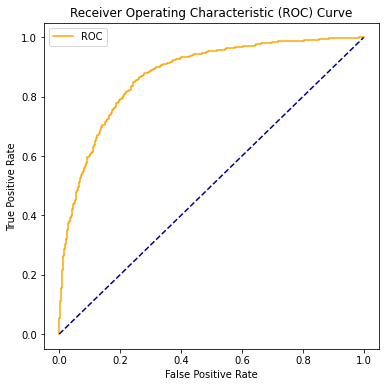

In [25]:
predictionProbabilities = lstm_model.predict(test_sequences_matrix) # Get the prediction probabilities (scores)

fpr, tpr, thresholds = roc_curve(Y_test, predictionProbabilities, pos_label = 1) # Calculate FPR and TPR

lr_auc = roc_auc_score(Y_test, predictionProbabilities) # Calculate AUC score
plt.rcParams['figure.figsize'] = (5, 5) # Determine the size of the plot
custom_plot_roc_curve(fpr, tpr, lr_auc) # Display ROC plot

In [26]:
from keras.models import load_model

lstm_model.save('model/drug_ex_model.h5')  # creates a HDF5 file 'my_model.h5'

# # Load the model:
# lstm_model = load_model('model/drug_ex_model.h5')

## 5. Apply the Classifier and Submit to Kaggle

Read the data file:

In [27]:
kaggle_test = pd.read_csv("data/test_DrugExp.csv", sep = "|")
kaggle_test.head()

,Id,text
0,1,osteoporosis Took the once a week 35 mg First ...
1,2,"osteoporosis 12 hours after first dose, experi..."
2,3,ADHD i am going crazy i dont sleep and if i do...
3,4,treatment resistant depression none i ll admit...
4,5,Because I felt like it my heartbeat was a litt...


Pre-process the data the same way we did in model building phase:

In [28]:
tqdm.pandas()
kaggle_test['text'] = kaggle_test.text.progress_apply(lambda text: 
                                          " ".join(token.lemma_ for token in nlp(text) 
                                                   if not token.is_stop and token.is_alpha))

/home/greermp/.local/lib/python3.8/site-packages/tqdm/std.py:702: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 2380/2380 [00:27<00:00, 86.10it/s]


Apply the GBM model and export it:

In [30]:
x = vectorizer.transform(kaggle_test.text)

predictionProbabilities = gbClassifier.predict_proba(x) 
kaggle_test['Expected'] = predictionProbabilities[:,1]

to_kaggle = kaggle_test[['Id','Expected']]

to_kaggle.to_csv('result/to_Kaggle_gb_model.csv', index=False)

Apply the LSTM model and export it:

In [31]:
test_sequences = tok.texts_to_sequences(kaggle_test.text)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

kaggle_test['Expected'] = lstm_model.predict(test_sequences_matrix)
to_kaggle = kaggle_test[['Id','Expected']]

to_kaggle.to_csv('result/to_Kaggle_lstm_model.csv', index=False)

Submit the file to https://www.kaggle.com/t/25177e2258c2412cae4924fa4a8777e8 